## Tutorial: Going through some theoretical properties of the DASF algorithm


In this tutorial, we will have a look at certain theoretical properties of the DASF algorithm.

Throughout this notebook, we will use the Linearly Constrained Minimum Variance (LCMV) problem as an example, written as:

$\text{min}_X\; \mathbb{E}[\|X^T\mathbf{y}(t)\|^2],\; \text{subject to }X^TB=H.$


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
from dasftoolbox import NetworkGraph, ConvergenceParameters
from dasftoolbox.optimization_problems.lcmv_problem import LCMVProblem
from dasftoolbox.data_retrievers.lcmv_data_retriever import LCMVDataRetriever
from dasftoolbox import DataWindowParameters
from dasftoolbox import DASF
from dasftoolbox import get_stationary_setting

random_seed = 2025
rng = np.random.default_rng(random_seed)

We select a fully connected network of 5 nodes, with 3 channels per node. We consider that there are 7 unknown source signals generating the observation $\mathbf{y}$, of which we will estimate 1, therefore $X$ will be a vector, i.e., will have $Q=1$ column.


In [2]:
nb_nodes = 5
nb_sensors_per_node = (3 * np.ones(nb_nodes)).astype(int)

nb_samples_per_window = 10000
nb_windows = 500

nb_sources = 7
nb_filters = 1

max_iterations = 300
data_window_params = get_stationary_setting(
    window_length=nb_samples_per_window, iterations=max_iterations
)
update_path = rng.permutation(range(nb_nodes))

lcmv_problem = LCMVProblem(nb_filters=nb_filters)
dasf_convergence_parameters = ConvergenceParameters(max_iterations=max_iterations)

adjacency_matrix = np.ones((nb_nodes, nb_nodes)) - np.eye(nb_nodes)
network_graph = NetworkGraph(
    nb_nodes=nb_nodes,
    nb_sensors_per_node=nb_sensors_per_node,
    adjacency_matrix=adjacency_matrix,
)

### Number of constraints of the problem


As a first analysis, we will look at how the number of constraints affect the convergence of the DASF algorithm. For the LCMV problem, the constraint is given by $X^TB=H$. If $X$ is $M\times Q$ and $B$ is $M\times L$, then there are $QL$ constraints in total.

If we call $J$ the total number of constraints, we need to satisfy either of the two conditions for guaranteeing convergence of the DASF algorithm:

- $J\leq Q^2$
- $J\leq \min\left(\frac{Q^2}{K-1}\sum_{k\in\mathcal{K}}n_k,\; (1+\min_{k\in\mathcal{K}} n_k)Q^2\right)$,

where $K$ is the number of nodes in the network - where each node is represented in the set $\mathcal{K}$ - and for each node $k$, $n_k$ represents the number of neighbor it has.

If one of these conditions is not satisfied, the DASF algorithm cannot be guaranteed to converge. The first condition is stricter, but is independent of the network, while the second condition is less restrictive and on top of being network dependent, is implicitly dependent on $X$, which makes it a condition that can only lead to convergence in probability.

In the LCMV scenario with a fully connected network, we have $J=QL$ and $\sum_{k\in\mathcal{K}}n_k=K-1$. Since $Q=1$, we either need $L\leq 1$ for the first condition, or $L\leq K$ for the second one.

Here, we will look at 3 different cases, for $L\in\{K-1,K,K+1\}$.


In [3]:
J = nb_nodes - 1
lcmv_data_retriever_valid = LCMVDataRetriever(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_sources,
    nb_windows=nb_windows,
    rng=rng,
    nb_filters=nb_filters,
    nb_steering=round(J / nb_filters),
)
dasf_lcmv_solver_valid = DASF(
    problem=lcmv_problem,
    data_retriever=lcmv_data_retriever_valid,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
)
B_matrix = lcmv_data_retriever_valid.get_data_window(window_id=0).fused_constants[0]
valid_contraints, nb_constraints = (
    dasf_lcmv_solver_valid.number_of_constraints_valid_for_convergence(
        constraints=lambda X: X.T @ B_matrix, return_constraints=True
    )
)
dasf_lcmv_solver_valid.run()

INFO:dasftoolbox.dasf:No convergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).
INFO:dasftoolbox.dasf:High probability that constraints are valid for convergence (dependent on the value of `X` and result cannot be generalized).


In [4]:
J = nb_nodes
lcmv_data_retriever_limit = LCMVDataRetriever(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_sources,
    nb_windows=nb_windows,
    rng=rng,
    nb_filters=nb_filters,
    nb_steering=round(J / nb_filters),
)
dasf_lcmv_solver_limit = DASF(
    problem=lcmv_problem.copy(),
    data_retriever=lcmv_data_retriever_limit,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
    initial_estimate=dasf_lcmv_solver_valid.initial_estimate,
)
B_matrix = lcmv_data_retriever_limit.get_data_window(window_id=0).fused_constants[0]
valid_contraints, nb_constraints = (
    dasf_lcmv_solver_limit.number_of_constraints_valid_for_convergence(
        constraints=lambda X: X.T @ B_matrix, return_constraints=True
    )
)
dasf_lcmv_solver_limit.run()

INFO:dasftoolbox.dasf:No convergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).
INFO:dasftoolbox.dasf:High probability that constraints are valid for convergence (dependent on the value of `X` and result cannot be generalized. The threshold is met with equality and can therefore impact convergence speed.


In [5]:
J = nb_nodes + 1
lcmv_data_retriever_exceeds = LCMVDataRetriever(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_sources,
    nb_windows=nb_windows,
    rng=rng,
    nb_filters=nb_filters,
    nb_steering=round(J / nb_filters),
)
dasf_lcmv_solver_exceeds = DASF(
    problem=lcmv_problem.copy(),
    data_retriever=lcmv_data_retriever_exceeds,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
    initial_estimate=dasf_lcmv_solver_valid.initial_estimate,
)
B_matrix = lcmv_data_retriever_exceeds.get_data_window(window_id=0).fused_constants[0]
valid_contraints, nb_constraints = (
    dasf_lcmv_solver_exceeds.number_of_constraints_valid_for_convergence(
        constraints=lambda X: X.T @ B_matrix, return_constraints=True
    )
)
dasf_lcmv_solver_exceeds.run()

INFO:dasftoolbox.dasf:No convergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).
INFO:dasftoolbox.dasf:Too many constraints, convergence not guaranteed. The number of constraints of the problem exceeds the theoretical threshold by 1.0.


Looking at the convergence plots, we see that for the case $J=K-1$, the second condition is strictly met and leads to convergence. For the case $J=K$ where the condition is met with equality, we see convergence seems to be slow, while $J=K+1$ leads to a scenario where the convergence is either very slow, or not obtained.


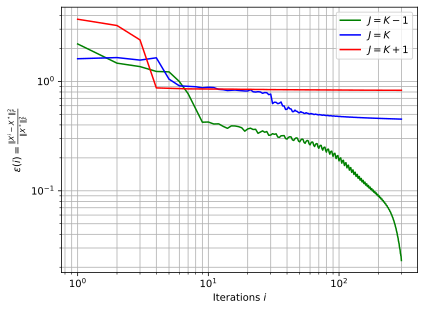

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(
    range(1, dasf_lcmv_solver_valid.total_iterations + 1),
    dasf_lcmv_solver_valid.normed_error_over_iterations[1:],
    color="g",
    label=r"$J=K-1$",
)
ax.loglog(
    range(1, dasf_lcmv_solver_limit.total_iterations + 1),
    dasf_lcmv_solver_limit.normed_error_over_iterations[1:],
    color="b",
    label=r"$J=K$",
)
ax.loglog(
    range(1, dasf_lcmv_solver_exceeds.total_iterations + 1),
    dasf_lcmv_solver_exceeds.normed_error_over_iterations[1:],
    color="r",
    label=r"$J=K+1$",
)

ax.set_xlabel(r"Iterations $i$")
ax.set_ylabel(r"$\varepsilon(i)=\frac{\|X^i-X^*\|_F^2}{\|X^*\|_F^2}$")
ax.grid(True, which="both")
plt.legend()

## Ill-posed problem


We now look into the ill-posed problem scenario, representing cases where small changes in inputs of the problem may not lead to small changes in the output of the problem. This usually happens when, e.g., the signals are redundant.

We simulate such a scenario by repeating every channel of $\mathbf{y}$ and adding a small amount of noise, so as to avoid having a singular correlation matrix of $\mathbf{y}$.


In [7]:
from dasftoolbox import ProblemInputs


class LCMVDataRetrieverIll(LCMVDataRetriever):
    def get_data_window(self, window_id: int) -> ProblemInputs:
        problem_inputs = super().get_data_window(window_id)
        Y = problem_inputs.fused_signals[0]
        Y_ill = Y
        Y_repeat = Y_ill[::2][: Y_ill[1::2].shape[0]]
        Y_ill[1::2] = Y_repeat + np.random.normal(
            loc=0, scale=0.1, size=(Y_repeat.shape)
        )
        problem_inputs_ill = ProblemInputs(
            fused_signals=[Y_ill],
            fused_constants=problem_inputs.fused_constants,
            global_parameters=problem_inputs.global_parameters,
        )
        return problem_inputs_ill


J = nb_nodes - 1
lcmv_data_retriever_ill = LCMVDataRetrieverIll(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_sources,
    nb_windows=nb_windows,
    rng=rng,
    nb_filters=nb_filters,
    nb_steering=round(J / nb_filters),
)

dasf_lcmv_solver_ill = DASF(
    problem=lcmv_problem.copy(),
    data_retriever=lcmv_data_retriever_ill,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
    initial_estimate=dasf_lcmv_solver_valid.initial_estimate,
)
dasf_lcmv_solver_ill.run()

INFO:dasftoolbox.dasf:No convergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).


We see below that the ill-posed problem prevents the DASF algorithm from converging.


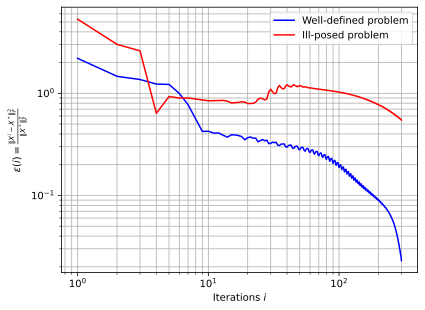

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(
    range(1, dasf_lcmv_solver_valid.total_iterations + 1),
    dasf_lcmv_solver_valid.normed_error_over_iterations[1:],
    color="b",
    label=r"Well-defined problem",
)
ax.loglog(
    range(1, dasf_lcmv_solver_ill.total_iterations + 1),
    dasf_lcmv_solver_ill.normed_error_over_iterations[1:],
    color="r",
    label=r"Ill-posed problem",
)

ax.set_xlabel(r"Iterations $i$")
ax.set_ylabel(r"$\varepsilon(i)=\frac{\|X^i-X^*\|_F^2}{\|X^*\|_F^2}$")
ax.grid(True, which="both")
plt.legend()

### Non-increasing objective


It can be shown that the DASF algorithm produces a sequence $\{X^i\}_i$ over iterations $i$ such that the sequence $\{f(X^i)\}_i$ of objective values of the problem is non-increasing (in case of a minimization, non-decreasing in case of a maximization). Here we create a new LCMV problem setting and verify this property.


In [ ]:
nb_nodes = 30
nb_sensors_per_node = (15 * np.ones(nb_nodes)).astype(int)
nb_filters = 5
adjacency_matrix = rng.integers(0, 1, size=(nb_nodes, nb_nodes), endpoint=True)
adjacency_matrix = np.triu(adjacency_matrix, 1) + np.tril(adjacency_matrix.T, -1)
network_graph = NetworkGraph(
    nb_nodes=nb_nodes,
    nb_sensors_per_node=nb_sensors_per_node,
    adjacency_matrix=adjacency_matrix,
)
lcmv_data_retriever = LCMVDataRetriever(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_filters,
    nb_filters=nb_filters,
    nb_windows=nb_windows,
    rng=rng,
)
lcmv_problem = LCMVProblem(nb_filters=nb_filters)
update_path = rng.permutation(range(nb_nodes))
dasf_lcmv_solver = DASF(
    problem=lcmv_problem,
    data_retriever=lcmv_data_retriever,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
)
dasf_lcmv_solver.run()

INFO:dasftoolbox.dasf:No convergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).


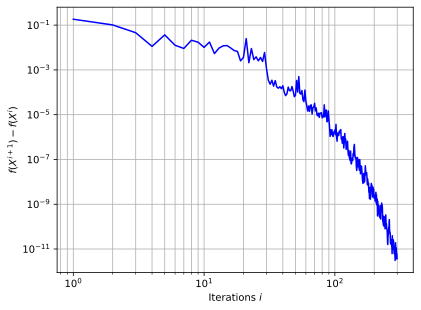

In [48]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
f_list = dasf_lcmv_solver.f_over_iterations[1:]
objective_diff = [f_list[i] - f_list[i + 1] for i in range(len(f_list) - 1)]
ax.loglog(
    range(1, dasf_lcmv_solver.total_iterations),
    objective_diff,
    color="b",
)

ax.set_xlabel(r"Iterations $i$")
ax.set_ylabel(r"$f(X^{i+1})-f(X^i)$")
ax.grid(True, which="both")

We can verify that the difference is indeed always non-negative.


In [49]:
df_summary = dasf_lcmv_solver.get_summary_df()
(df_summary["objective_error"].diff(-1).dropna() >= 0).all()

True